<a href="https://colab.research.google.com/github/Anya232536/study_hse/blob/main/mesa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mesa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 3.5 MB/s eta 0:00:00


In [ ]:
from mesa import Agent, Model
from mesa.datacollection import DataCollector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

Модель


In [ ]:
class MyAgent(Agent):

  def __init__(self, model, id, x, u, extremism_flg = False):
    super().__init__(model)
    self.id = id
    self.x = x
    self.u = u
    self.extremism_flg = extremism_flg

  def step(self):

    if self.model.pairwise:

      if self.id not in self.model.made_step:
        is_valid_pair = False
        while not is_valid_pair:

          other_agent = self.random.choice(self.model.agents)
          if other_agent.id not in self.model.made_step \
                            and other_agent.id != self.id:
            is_valid_pair = True

        if self.x + self.u > other_agent.x - other_agent.u and self.x - self.u < other_agent.x + other_agent.u:
          h_ij = min(self.x + self.u, other_agent.x + other_agent.u) - max(self.x - self.u, other_agent.x - other_agent.u)

          x_other = other_agent.x
          u_other = other_agent.u

          if h_ij > self.u:

            other_agent.x = other_agent.x + self.model.mu * (h_ij / self.u - 1) * (self.x - other_agent.x)
            other_agent.u = other_agent.u + self.model.mu * (h_ij / self.u - 1) * (self.u - other_agent.u)

            if other_agent.x > 1:
                other_agent.x = 1
            elif other_agent.x < -1:
                other_agent.x = -1

          if h_ij > u_other:

            self.x = self.x + self.model.mu * (h_ij / u_other - 1) * (x_other - self.x)
            self.u = self.u + self.model.mu * (h_ij / u_other - 1) * (u_other - self.u)

            if self.x > 1:
                self.x = 1
            elif self.x < -1:
                self.x = -1

        self.model.made_step += [self.id, other_agent.id]


    else:
      self.x_list = []
      self.u_list = []

      for other_agent in self.model.agents:
          if other_agent.id != self.id:
              if self.x + self.u > other_agent.x - other_agent.u and self.x - self.u < other_agent.x + other_agent.u:
                  h_ij = min(self.x + self.u, other_agent.x + other_agent.u) - max(self.x - self.u, other_agent.x - other_agent.u)

                  if h_ij > other_agent.u:

                      x_add = self.model.mu * (h_ij / other_agent.u - 1) * (other_agent.x - self.x)
                      u_add = self.model.mu * (h_ij / other_agent.u - 1) * (other_agent.u - self.u)

                      if x_add > 1:
                          x_add = 1
                      elif x_add < -1:
                          x_add = -1

                      self.x_list.append(x_add)
                      self.u_list.append(u_add)
          else:
              continue

      self.model.x_news[self.id] = self.x + sum(self.x_list)
      self.model.u_news[self.id] = self.u + sum(self.u_list)


In [ ]:
class MyModel(Model):
  def __init__(self, u=1.2, u_e=0.1, mu=0.5, p_e=0.2, delta=0, N=1000, pairwise=True, seed=42):
        super().__init__(seed=seed)
        self.num_agents = N # число агентов N
        self.u = u # степень неуверенности обычных агентов
        self.u_e = u_e # степень неуверенности экстремистов
        self.mu = mu # степень чувствительности к чужому мнению
        self.p_e = p_e # доля экстремистов от N
        self.delta = delta # дельта из статьи
                           # (относительная разница между долей поз. и нег. экстр.)
        self.pairwise = pairwise # режим взаимодействия

        if self.pairwise == False:
            self.mu /= (self.num_agents - 1)


        x_rand_gen = np.random.uniform(-1, 1, self.num_agents)
        p_pos_div_p_neg = (1 + self.delta) / (1 - self.delta)

        N_neg_extr = int((self.num_agents * self.p_e) / (1 + p_pos_div_p_neg))
        N_pos_extr = int(self.num_agents * self.p_e) - N_neg_extr

        idxs_neg_extr = np.argpartition(x_rand_gen, N_neg_extr)[:N_neg_extr]
        idxs_pos_extr = np.argpartition(x_rand_gen, -N_pos_extr)[-N_pos_extr:]
        if self.pairwise:
            self.made_step = []

        else:
            self.x_news = [0 for _ in range(self.num_agents)]
            self.u_news = [0 for _ in range(self.num_agents)]

        for i, x in enumerate(x_rand_gen):
            if (i not in idxs_neg_extr) and (i not in idxs_pos_extr):
                a = MyAgent(self, i, x, self.u)
            else:
                a = MyAgent(self, i, x, self.u_e, True)

        self.datacollector = DataCollector(
            agent_reporters={"Opinions": "x", "U": "u"}) #собираем данные

  def step(self):
      self.datacollector.collect(self)
      #self.schedule.step()
      self.agents.shuffle_do("step")
      if self.pairwise:
          self.made_step = []
      else:
          for a in self.agents:
              a.x = self.x_news[a.id]
              a.u = self.u_news[a.id]
          self.x_news = [0 for _ in range(self.num_agents)]
          self.u_news = [0 for _ in range(self.num_agents)]

In [ ]:
model = MyModel(N=200)
for i in range(225):
    model.step()

<ipython-input-18-084ae232fbfd>:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  opinion_data.T.stack().T.plot(legend=False, figsize=(12,6))


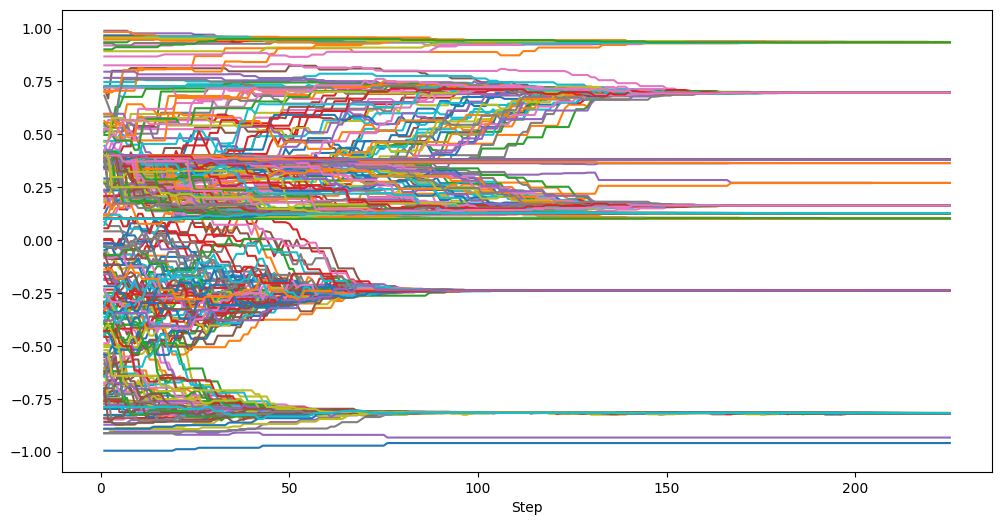

In [ ]:
model = MyModel(u = 0.4, N=200)

for i in range(225):
    model.step()
opinion_data = model.datacollector.get_agent_vars_dataframe()
opinion_data.T.stack().T.plot(legend=False, figsize=(12,6))
plt.show()

<ipython-input-19-a77ea4fd43a2>:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  opinion_data.T.stack().T.plot(legend=False, figsize=(12,6))


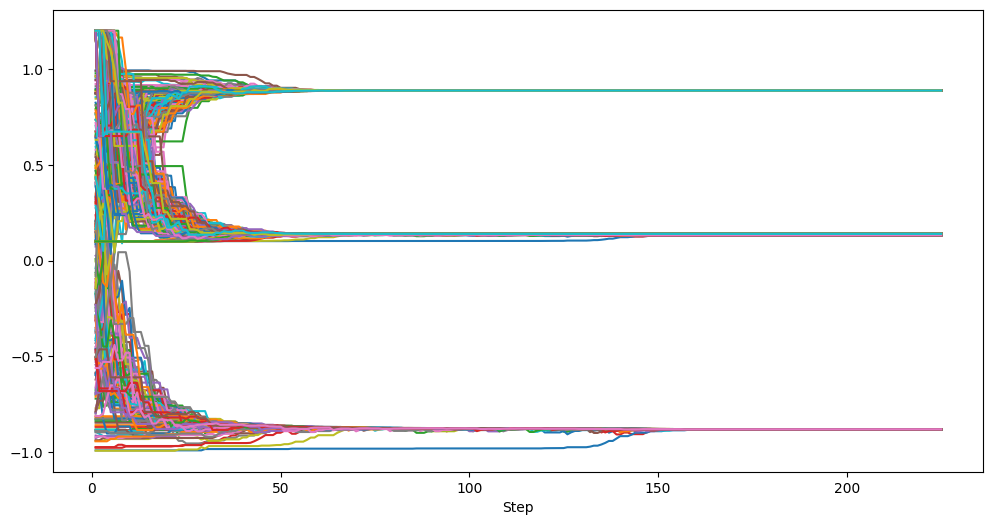

In [ ]:
model = MyModel(u = 1.2, p_e = 0.25, N=200)

for i in range(225):
    model.step()
opinion_data = model.datacollector.get_agent_vars_dataframe()
opinion_data.T.stack().T.plot(legend=False, figsize=(12,6))
plt.show()

<ipython-input-20-6a61c2a74b7f>:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  opinion_data.T.stack().T.plot(legend=False, figsize=(12,6))


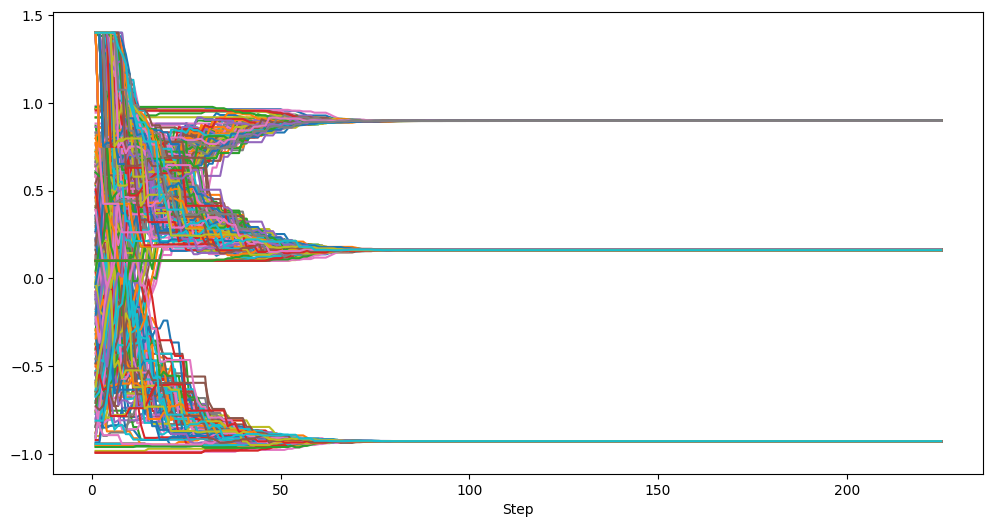

In [ ]:
model = MyModel(u = 1.4, p_e = 0.1, N=200)

for i in range(225):
    model.step()
opinion_data = model.datacollector.get_agent_vars_dataframe()
opinion_data.T.stack().T.plot(legend=False, figsize=(12,6))
plt.show()

<ipython-input-21-779960757441>:5: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  opinion_data.T.stack().T.plot(legend=False, figsize=(12,6))


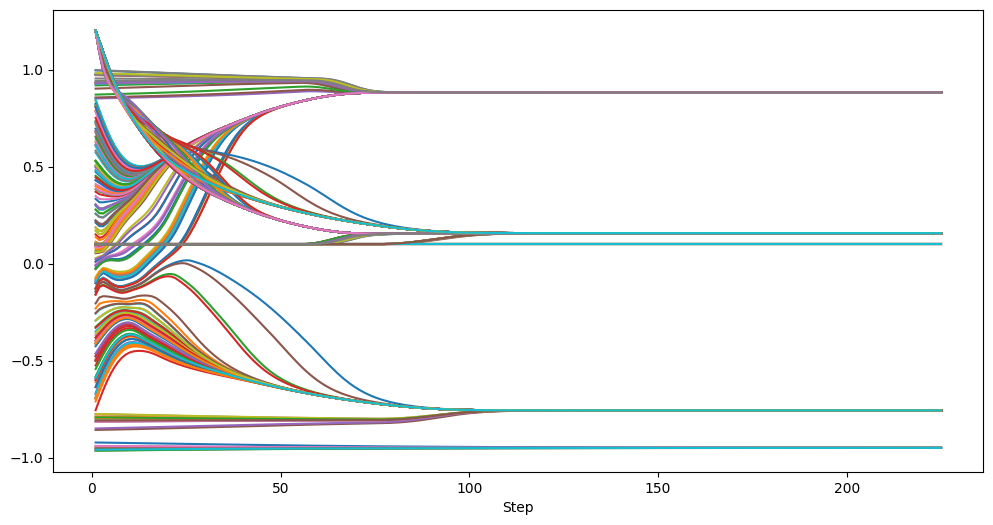

In [ ]:
model = MyModel(N=200, pairwise=False)
for i in range(225):
    model.step()
opinion_data = model.datacollector.get_agent_vars_dataframe()
opinion_data.T.stack().T.plot(legend=False, figsize=(12,6))
plt.show()

<ipython-input-22-e7c80a2a32bd>:5: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  opinion_data.T.stack().T.plot(legend=False, figsize=(12,6))


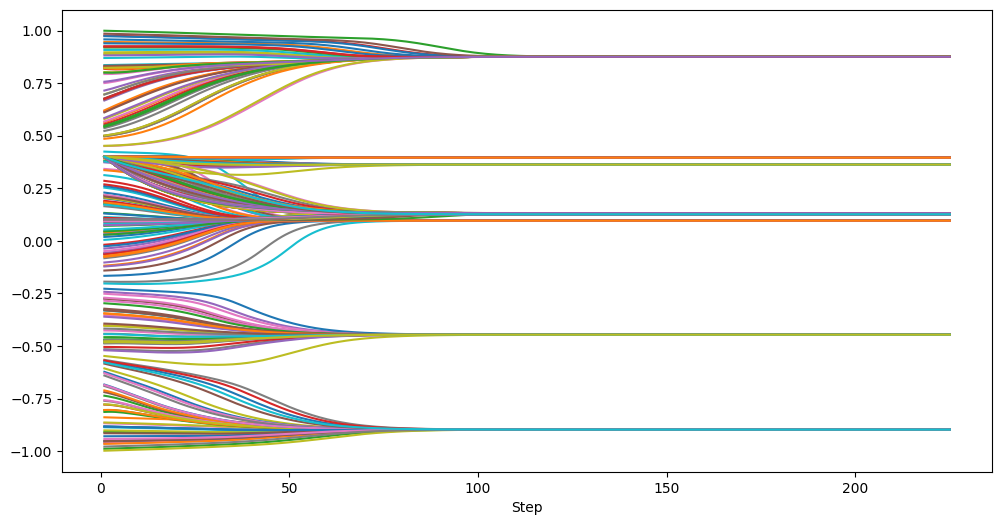

In [ ]:
model = MyModel(u=0.4, p_e=0.2, N=200, pairwise=False)
for i in range(225):
    model.step()
opinion_data = model.datacollector.get_agent_vars_dataframe()
opinion_data.T.stack().T.plot(legend=False, figsize=(12,6))
plt.show()

Сходимость и собираем датасет для ML моделей

Считаю, что сошлось, если метрики всех агентов за последние 5 шагов меняются не больше чем на эпсилон

In [ ]:
def check_convergence(model):

  for i in range(200):
      model.step()

  new_df = pd.DataFrame()

  df_opinion = model.datacollector.get_agent_vars_dataframe()[['Opinions']]
  df_u = model.datacollector.get_agent_vars_dataframe()[['U']]
  for ag_id in df_opinion.index.get_level_values(1).unique():
        op = df_opinion.loc[pd.IndexSlice[:, ag_id], :].droplevel(1).rename(columns={'Opinions': f'Opinions: {ag_id}'})
        u = df_u.loc[pd.IndexSlice[:, ag_id], :].droplevel(1).rename(columns={'U': f'U: {ag_id}'})
        new_df = pd.concat([new_df, op, u], axis=1)

  recent_diff = new_df.iloc[-6:].diff().dropna().abs()
  if recent_diff.lt(0.01).all().all():
    print('сходимость')
    return True, new_df
  else:
    return False, new_df

In [ ]:
import itertools

train_df = pd.DataFrame(columns=['u', 'u_e', 'mu', 'p_e', 'delta', 'y'])

p_e_lst = [0.035, 0.15, 0.25, 0.35]
u_lst = [0.25, 0.45, 1.3, 1.5]
u_e_lst = [0.07, 0.17, 0.23, 0.31]
delta_lst = [0, 0.25, 0.45, 0.55]
mu_lst = [0.35, 0.55]

prod_list = itertools.product(u_lst, u_e_lst, mu_lst, p_e_lst, delta_lst)
prod_list = list(prod_list)

In [ ]:
def extract_values(df, prefix, step=199):
    columns = df.columns.str.startswith(prefix)
    return df.reset_index().drop('Step', axis=1).T.loc[columns, step].reset_index(drop=True).round(2).values

In [ ]:
k=0
transformer_train_array = np.array([])

for el in prod_list:
    k += 1
    u, u_e, mu, p_e, delta = el
    model_test = MyModel(u=u, u_e=u_e, mu=mu, p_e=p_e, delta=delta, N=200, pairwise=False)
    for i in tqdm(range(200)):
        model_test.step()
    is_stat, df = check_convergence(model_test)
    if is_stat == True:
      x_array = extract_values(df, 'Opinions')
      u_array = extract_values(df, 'U')

      stationary_state = x_array.round(2)
      cluster_counts = np.unique(stationary_state, return_counts=True)[1]
      number_of_clusters = np.array([len(cluster_counts)])
      print(number_of_clusters)

      X = np.concatenate([x_array, u_array, number_of_clusters])
      X = X.reshape(-1, 1).T

      print(transformer_train_array.shape)

      if len(transformer_train_array) == 0:
        transformer_train_array = X
      else:
        transformer_train_array = np.concatenate([transformer_train_array, X], axis=0)

      d = {'u':[u], 'u_e':[u_e], 'mu':[mu], 'p_e':[p_e],
              'delta':[delta], 'y': number_of_clusters}

      temp_df = pd.DataFrame(d)
      train_df = pd.concat([train_df, temp_df], ignore_index=True)

pca_model = PCA(n_components=1)

y_embedding = pca_model.fit_transform(transformer_train_array)
train_df['y_pca'] = y_embedding.reshape(-1)


100%|██████████| 200/200 [00:11<00:00, 17.12it/s]
<ipython-input-8-33c75de21f50>:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([train_df, temp_df], ignore_index=True)


сходимость
[11]
(0,)


100%|██████████| 200/200 [00:11<00:00, 17.27it/s]


сходимость
[12]
(1, 401)


100%|██████████| 200/200 [00:11<00:00, 17.71it/s]


сходимость
[9]
(2, 401)


100%|██████████| 200/200 [00:09<00:00, 20.27it/s]


сходимость
[6]
(3, 401)


100%|██████████| 200/200 [00:09<00:00, 20.67it/s]


сходимость
[14]
(4, 401)


100%|██████████| 200/200 [00:10<00:00, 19.23it/s]


сходимость
[23]
(5, 401)


100%|██████████| 200/200 [00:10<00:00, 19.19it/s]


сходимость
[22]
(6, 401)


100%|██████████| 200/200 [00:11<00:00, 18.09it/s]


сходимость
[11]
(7, 401)


100%|██████████| 200/200 [00:10<00:00, 19.38it/s]


сходимость
[24]
(8, 401)


100%|██████████| 200/200 [00:10<00:00, 19.56it/s]


сходимость
[17]
(9, 401)


100%|██████████| 200/200 [00:09<00:00, 20.12it/s]


сходимость
[17]
(10, 401)


100%|██████████| 200/200 [00:09<00:00, 20.11it/s]


сходимость
[16]
(11, 401)


100%|██████████| 200/200 [00:09<00:00, 22.01it/s]


сходимость
[37]
(12, 401)


100%|██████████| 200/200 [00:08<00:00, 22.34it/s]


сходимость
[27]
(13, 401)


100%|██████████| 200/200 [00:08<00:00, 24.19it/s]


сходимость
[25]
(14, 401)


100%|██████████| 200/200 [00:09<00:00, 20.37it/s]


сходимость
[22]
(15, 401)


100%|██████████| 200/200 [00:10<00:00, 19.89it/s]


сходимость
[5]
(16, 401)


100%|██████████| 200/200 [00:10<00:00, 18.50it/s]


сходимость
[6]
(17, 401)


100%|██████████| 200/200 [00:10<00:00, 18.19it/s]


сходимость
[6]
(18, 401)


100%|██████████| 200/200 [00:11<00:00, 18.08it/s]


сходимость
[8]
(19, 401)


100%|██████████| 200/200 [00:10<00:00, 18.95it/s]


сходимость
[7]
(20, 401)


100%|██████████| 200/200 [00:10<00:00, 19.31it/s]


сходимость
[10]
(21, 401)


100%|██████████| 200/200 [00:10<00:00, 19.52it/s]


сходимость
[10]
(22, 401)


100%|██████████| 200/200 [00:11<00:00, 17.95it/s]


сходимость
[12]
(23, 401)


100%|██████████| 200/200 [00:10<00:00, 19.75it/s]


сходимость
[9]
(24, 401)


100%|██████████| 200/200 [00:09<00:00, 20.41it/s]


сходимость
[8]
(25, 401)


100%|██████████| 200/200 [00:10<00:00, 19.46it/s]


сходимость
[18]
(26, 401)


100%|██████████| 200/200 [00:10<00:00, 19.01it/s]


сходимость
[13]
(27, 401)


100%|██████████| 200/200 [00:09<00:00, 20.54it/s]


сходимость
[15]
(28, 401)


100%|██████████| 200/200 [00:09<00:00, 20.87it/s]


сходимость
[14]
(29, 401)


100%|██████████| 200/200 [00:09<00:00, 20.77it/s]


сходимость
[14]
(30, 401)


100%|██████████| 200/200 [00:10<00:00, 19.96it/s]


сходимость
[14]
(31, 401)


100%|██████████| 200/200 [00:11<00:00, 17.14it/s]


сходимость
[6]
(32, 401)


100%|██████████| 200/200 [00:11<00:00, 17.64it/s]


сходимость
[6]
(33, 401)


100%|██████████| 200/200 [00:11<00:00, 16.99it/s]


сходимость
[6]
(34, 401)


100%|██████████| 200/200 [00:11<00:00, 18.09it/s]


сходимость
[8]
(35, 401)


100%|██████████| 200/200 [00:10<00:00, 18.69it/s]


сходимость
[7]
(36, 401)


100%|██████████| 200/200 [00:10<00:00, 19.19it/s]


сходимость
[7]
(37, 401)


100%|██████████| 200/200 [00:11<00:00, 17.46it/s]


сходимость
[8]
(38, 401)


100%|██████████| 200/200 [00:11<00:00, 16.87it/s]


сходимость
[10]
(39, 401)


100%|██████████| 200/200 [00:10<00:00, 18.30it/s]


сходимость
[6]
(40, 401)


100%|██████████| 200/200 [00:10<00:00, 18.58it/s]


сходимость
[10]
(41, 401)


100%|██████████| 200/200 [00:10<00:00, 18.97it/s]


сходимость
[5]
(42, 401)


100%|██████████| 200/200 [00:10<00:00, 18.93it/s]


сходимость
[7]
(43, 401)


100%|██████████| 200/200 [00:11<00:00, 18.12it/s]


сходимость
[16]
(44, 401)


100%|██████████| 200/200 [00:10<00:00, 18.55it/s]


сходимость
[8]
(45, 401)


100%|██████████| 200/200 [00:10<00:00, 18.76it/s]


сходимость
[6]
(46, 401)


100%|██████████| 200/200 [00:10<00:00, 18.70it/s]


сходимость
[11]
(47, 401)


100%|██████████| 200/200 [00:10<00:00, 18.86it/s]


сходимость
[4]
(48, 401)


100%|██████████| 200/200 [00:11<00:00, 17.33it/s]


сходимость
[6]
(49, 401)


100%|██████████| 200/200 [00:11<00:00, 17.00it/s]


сходимость
[8]
(50, 401)


100%|██████████| 200/200 [00:11<00:00, 18.18it/s]


сходимость
[4]
(51, 401)


100%|██████████| 200/200 [00:09<00:00, 20.52it/s]


сходимость
[4]
(52, 401)


100%|██████████| 200/200 [00:09<00:00, 20.08it/s]


сходимость
[5]
(53, 401)


100%|██████████| 200/200 [00:11<00:00, 17.77it/s]


сходимость
[5]
(54, 401)


100%|██████████| 200/200 [00:10<00:00, 18.68it/s]


сходимость
[5]
(55, 401)


100%|██████████| 200/200 [00:11<00:00, 17.31it/s]


сходимость
[4]
(56, 401)


100%|██████████| 200/200 [00:10<00:00, 18.43it/s]


сходимость
[5]
(57, 401)


100%|██████████| 200/200 [00:10<00:00, 18.59it/s]


сходимость
[4]
(58, 401)


100%|██████████| 200/200 [00:11<00:00, 18.05it/s]


сходимость
[6]
(59, 401)


100%|██████████| 200/200 [00:11<00:00, 17.97it/s]


сходимость
[7]
(60, 401)


100%|██████████| 200/200 [00:10<00:00, 19.17it/s]


сходимость
[6]
(61, 401)


100%|██████████| 200/200 [00:11<00:00, 18.16it/s]


сходимость
[6]
(62, 401)


100%|██████████| 200/200 [00:10<00:00, 19.87it/s]


сходимость
[6]
(63, 401)


100%|██████████| 200/200 [00:11<00:00, 17.01it/s]


сходимость
[5]
(64, 401)


100%|██████████| 200/200 [00:11<00:00, 17.25it/s]


сходимость
[4]
(65, 401)


100%|██████████| 200/200 [00:11<00:00, 17.36it/s]


сходимость
[6]
(66, 401)


100%|██████████| 200/200 [00:11<00:00, 17.50it/s]


сходимость
[8]
(67, 401)


100%|██████████| 200/200 [00:12<00:00, 16.29it/s]


сходимость
[5]
(68, 401)


100%|██████████| 200/200 [00:11<00:00, 16.88it/s]


сходимость
[6]
(69, 401)


100%|██████████| 200/200 [00:11<00:00, 16.67it/s]


сходимость
[7]
(70, 401)


100%|██████████| 200/200 [00:11<00:00, 17.21it/s]


сходимость
[8]
(71, 401)


100%|██████████| 200/200 [00:11<00:00, 17.60it/s]


сходимость
[10]
(72, 401)


100%|██████████| 200/200 [00:11<00:00, 17.51it/s]


сходимость
[9]
(73, 401)


100%|██████████| 200/200 [00:11<00:00, 17.63it/s]


сходимость
[8]
(74, 401)


100%|██████████| 200/200 [00:10<00:00, 18.70it/s]


сходимость
[5]
(75, 401)


100%|██████████| 200/200 [00:11<00:00, 17.59it/s]


сходимость
[7]
(76, 401)


100%|██████████| 200/200 [00:10<00:00, 18.22it/s]


сходимость
[16]
(77, 401)


100%|██████████| 200/200 [00:11<00:00, 17.13it/s]


сходимость
[5]
(78, 401)


100%|██████████| 200/200 [00:11<00:00, 17.45it/s]


сходимость
[6]
(79, 401)


100%|██████████| 200/200 [00:11<00:00, 16.78it/s]


сходимость
[5]
(80, 401)


100%|██████████| 200/200 [00:11<00:00, 17.33it/s]


сходимость
[4]
(81, 401)


100%|██████████| 200/200 [00:12<00:00, 15.97it/s]


сходимость
[5]
(82, 401)


100%|██████████| 200/200 [00:11<00:00, 17.03it/s]


сходимость
[5]
(83, 401)


100%|██████████| 200/200 [00:11<00:00, 17.12it/s]


сходимость
[5]
(84, 401)


100%|██████████| 200/200 [00:10<00:00, 19.33it/s]


сходимость
[5]
(85, 401)


100%|██████████| 200/200 [00:11<00:00, 16.75it/s]


сходимость
[4]
(86, 401)


100%|██████████| 200/200 [00:11<00:00, 16.67it/s]


сходимость
[5]
(87, 401)


100%|██████████| 200/200 [00:11<00:00, 17.07it/s]


сходимость
[5]
(88, 401)


100%|██████████| 200/200 [00:11<00:00, 16.99it/s]


сходимость
[6]
(89, 401)


100%|██████████| 200/200 [00:11<00:00, 17.59it/s]


сходимость
[5]
(90, 401)


100%|██████████| 200/200 [00:11<00:00, 16.97it/s]


сходимость
[5]
(91, 401)


100%|██████████| 200/200 [00:11<00:00, 17.08it/s]


сходимость
[5]
(92, 401)


100%|██████████| 200/200 [00:11<00:00, 16.96it/s]


сходимость
[4]
(93, 401)


100%|██████████| 200/200 [00:11<00:00, 17.53it/s]


сходимость
[10]
(94, 401)


100%|██████████| 200/200 [00:11<00:00, 17.28it/s]


сходимость
[5]
(95, 401)


100%|██████████| 200/200 [00:11<00:00, 17.18it/s]


сходимость
[5]
(96, 401)


100%|██████████| 200/200 [00:12<00:00, 16.42it/s]


сходимость
[5]
(97, 401)


100%|██████████| 200/200 [00:11<00:00, 17.15it/s]


сходимость
[9]
(98, 401)


100%|██████████| 200/200 [00:10<00:00, 18.99it/s]


сходимость
[4]
(99, 401)


100%|██████████| 200/200 [00:13<00:00, 14.97it/s]


сходимость
[9]
(100, 401)


100%|██████████| 200/200 [00:11<00:00, 16.72it/s]


сходимость
[5]
(101, 401)


100%|██████████| 200/200 [00:11<00:00, 17.00it/s]


сходимость
[7]
(102, 401)


100%|██████████| 200/200 [00:11<00:00, 16.87it/s]


сходимость
[4]
(103, 401)


100%|██████████| 200/200 [00:11<00:00, 17.11it/s]


сходимость
[4]
(104, 401)


100%|██████████| 200/200 [00:12<00:00, 16.21it/s]


сходимость
[6]
(105, 401)


100%|██████████| 200/200 [00:13<00:00, 15.24it/s]


сходимость
[6]
(106, 401)


100%|██████████| 200/200 [00:13<00:00, 15.22it/s]


сходимость
[3]
(107, 401)


100%|██████████| 200/200 [00:12<00:00, 15.60it/s]


сходимость
[5]
(108, 401)


100%|██████████| 200/200 [00:12<00:00, 15.74it/s]


сходимость
[9]
(109, 401)


100%|██████████| 200/200 [00:12<00:00, 16.44it/s]


сходимость
[5]
(110, 401)


100%|██████████| 200/200 [00:12<00:00, 16.60it/s]


сходимость
[3]
(111, 401)


100%|██████████| 200/200 [00:12<00:00, 16.16it/s]


сходимость
[5]
(112, 401)


100%|██████████| 200/200 [00:12<00:00, 16.35it/s]


сходимость
[6]
(113, 401)


100%|██████████| 200/200 [00:11<00:00, 16.89it/s]


сходимость
[4]
(114, 401)


100%|██████████| 200/200 [00:11<00:00, 17.92it/s]


сходимость
[4]
(115, 401)


100%|██████████| 200/200 [00:12<00:00, 16.49it/s]


сходимость
[4]
(116, 401)


100%|██████████| 200/200 [00:12<00:00, 16.52it/s]


сходимость
[4]
(117, 401)


100%|██████████| 200/200 [00:11<00:00, 16.92it/s]


сходимость
[4]
(118, 401)


100%|██████████| 200/200 [00:11<00:00, 17.03it/s]


сходимость
[6]
(119, 401)


100%|██████████| 200/200 [00:12<00:00, 15.58it/s]


сходимость
[4]
(120, 401)


100%|██████████| 200/200 [00:11<00:00, 17.40it/s]


сходимость
[4]
(121, 401)


100%|██████████| 200/200 [00:11<00:00, 17.12it/s]


сходимость
[5]
(122, 401)


100%|██████████| 200/200 [00:11<00:00, 16.73it/s]


сходимость
[5]
(123, 401)


100%|██████████| 200/200 [00:12<00:00, 15.92it/s]


сходимость
[4]
(124, 401)


100%|██████████| 200/200 [00:13<00:00, 14.94it/s]


сходимость
[4]
(125, 401)


100%|██████████| 200/200 [00:12<00:00, 15.66it/s]


сходимость
[5]
(126, 401)


100%|██████████| 200/200 [00:13<00:00, 15.05it/s]


сходимость
[4]
(127, 401)


100%|██████████| 200/200 [00:13<00:00, 14.51it/s]


сходимость
[6]
(128, 401)


100%|██████████| 200/200 [00:13<00:00, 15.16it/s]


сходимость
[6]
(129, 401)


100%|██████████| 200/200 [00:14<00:00, 13.53it/s]


сходимость
[8]
(130, 401)


100%|██████████| 200/200 [00:13<00:00, 14.58it/s]


сходимость
[7]
(131, 401)


100%|██████████| 200/200 [00:11<00:00, 17.10it/s]


сходимость
[6]
(132, 401)


100%|██████████| 200/200 [00:11<00:00, 17.27it/s]


сходимость
[6]
(133, 401)


100%|██████████| 200/200 [00:12<00:00, 16.09it/s]


сходимость
[11]
(134, 401)


100%|██████████| 200/200 [00:13<00:00, 14.51it/s]


сходимость
[13]
(135, 401)


100%|██████████| 200/200 [00:11<00:00, 18.01it/s]


сходимость
[6]
(136, 401)


100%|██████████| 200/200 [00:11<00:00, 17.30it/s]


сходимость
[8]
(137, 401)


100%|██████████| 200/200 [00:10<00:00, 19.60it/s]


сходимость
[13]
(138, 401)


100%|██████████| 200/200 [00:10<00:00, 18.25it/s]


сходимость
[19]
(139, 401)


100%|██████████| 200/200 [00:10<00:00, 19.55it/s]


сходимость
[24]
(140, 401)


100%|██████████| 200/200 [00:10<00:00, 18.57it/s]


сходимость
[30]
(141, 401)


100%|██████████| 200/200 [00:10<00:00, 19.85it/s]


сходимость
[17]
(142, 401)


100%|██████████| 200/200 [00:11<00:00, 17.88it/s]


сходимость
[22]
(143, 401)


100%|██████████| 200/200 [00:12<00:00, 15.41it/s]


сходимость
[6]
(144, 401)


100%|██████████| 200/200 [00:15<00:00, 13.13it/s]


сходимость
[5]
(145, 401)


100%|██████████| 200/200 [00:14<00:00, 13.34it/s]


сходимость
[4]
(146, 401)


100%|██████████| 200/200 [00:13<00:00, 14.52it/s]


сходимость
[4]
(147, 401)


100%|██████████| 200/200 [00:12<00:00, 16.19it/s]


сходимость
[3]
(148, 401)


100%|██████████| 200/200 [00:11<00:00, 16.96it/s]


сходимость
[6]
(149, 401)


100%|██████████| 200/200 [00:12<00:00, 16.06it/s]


сходимость
[7]
(150, 401)


100%|██████████| 200/200 [00:11<00:00, 16.79it/s]


сходимость
[5]
(151, 401)


100%|██████████| 200/200 [00:11<00:00, 17.73it/s]


сходимость
[6]
(152, 401)


100%|██████████| 200/200 [00:11<00:00, 17.53it/s]


сходимость
[7]
(153, 401)


100%|██████████| 200/200 [00:10<00:00, 18.85it/s]


сходимость
[11]
(154, 401)


100%|██████████| 200/200 [00:10<00:00, 18.47it/s]


сходимость
[12]
(155, 401)


100%|██████████| 200/200 [00:10<00:00, 19.58it/s]


сходимость
[12]
(156, 401)


100%|██████████| 200/200 [00:10<00:00, 19.28it/s]


сходимость
[8]
(157, 401)


100%|██████████| 200/200 [00:10<00:00, 19.85it/s]


сходимость
[8]
(158, 401)


100%|██████████| 200/200 [00:10<00:00, 19.91it/s]


сходимость
[17]
(159, 401)


100%|██████████| 200/200 [00:13<00:00, 14.95it/s]


сходимость
[5]
(160, 401)


100%|██████████| 200/200 [00:14<00:00, 14.05it/s]


сходимость
[5]
(161, 401)


100%|██████████| 200/200 [00:14<00:00, 13.72it/s]


сходимость
[5]
(162, 401)


100%|██████████| 200/200 [00:14<00:00, 13.44it/s]


сходимость
[6]
(163, 401)


100%|██████████| 200/200 [00:13<00:00, 14.46it/s]


сходимость
[3]
(164, 401)


100%|██████████| 200/200 [00:13<00:00, 15.09it/s]


сходимость
[3]
(165, 401)


100%|██████████| 200/200 [00:15<00:00, 12.57it/s]


сходимость
[11]
(166, 401)


100%|██████████| 200/200 [00:14<00:00, 14.08it/s]


сходимость
[4]
(167, 401)


100%|██████████| 200/200 [00:12<00:00, 16.53it/s]


сходимость
[3]
(168, 401)


100%|██████████| 200/200 [00:11<00:00, 17.12it/s]


сходимость
[3]
(169, 401)


100%|██████████| 200/200 [00:13<00:00, 15.11it/s]


сходимость
[6]
(170, 401)


100%|██████████| 200/200 [00:11<00:00, 16.92it/s]


сходимость
[10]
(171, 401)


100%|██████████| 200/200 [00:12<00:00, 15.84it/s]


сходимость
[4]
(172, 401)


100%|██████████| 200/200 [00:11<00:00, 17.20it/s]


сходимость
[5]
(173, 401)


100%|██████████| 200/200 [00:11<00:00, 16.95it/s]


сходимость
[9]
(174, 401)


100%|██████████| 200/200 [00:12<00:00, 15.84it/s]


сходимость
[5]
(175, 401)


100%|██████████| 200/200 [00:14<00:00, 13.88it/s]


сходимость
[5]
(176, 401)


100%|██████████| 200/200 [00:14<00:00, 13.84it/s]


сходимость
[4]
(177, 401)


100%|██████████| 200/200 [00:13<00:00, 14.65it/s]


сходимость
[4]
(178, 401)


100%|██████████| 200/200 [00:13<00:00, 14.58it/s]


сходимость
[4]
(179, 401)


100%|██████████| 200/200 [00:13<00:00, 15.29it/s]


сходимость
[4]
(180, 401)


100%|██████████| 200/200 [00:11<00:00, 16.83it/s]


сходимость
[3]
(181, 401)


100%|██████████| 200/200 [00:12<00:00, 16.33it/s]


сходимость
[3]
(182, 401)


100%|██████████| 200/200 [00:12<00:00, 15.65it/s]


сходимость
[3]
(183, 401)


100%|██████████| 200/200 [00:11<00:00, 17.02it/s]


сходимость
[4]
(184, 401)


100%|██████████| 200/200 [00:12<00:00, 16.50it/s]


сходимость
[3]
(185, 401)


100%|██████████| 200/200 [00:13<00:00, 15.38it/s]


сходимость
[4]
(186, 401)


100%|██████████| 200/200 [00:11<00:00, 17.23it/s]


сходимость
[4]
(187, 401)


100%|██████████| 200/200 [00:11<00:00, 17.20it/s]


сходимость
[3]
(188, 401)


100%|██████████| 200/200 [00:11<00:00, 17.32it/s]


сходимость
[4]
(189, 401)


100%|██████████| 200/200 [00:12<00:00, 16.27it/s]


сходимость
[3]
(190, 401)


100%|██████████| 200/200 [00:11<00:00, 17.78it/s]


сходимость
[4]
(191, 401)


100%|██████████| 200/200 [00:14<00:00, 13.50it/s]


сходимость
[4]
(192, 401)


100%|██████████| 200/200 [00:14<00:00, 13.94it/s]


сходимость
[7]
(193, 401)


100%|██████████| 200/200 [00:14<00:00, 13.68it/s]


сходимость
[6]
(194, 401)


100%|██████████| 200/200 [00:15<00:00, 13.04it/s]


сходимость
[5]
(195, 401)


100%|██████████| 200/200 [00:14<00:00, 13.89it/s]


сходимость
[3]
(196, 401)


100%|██████████| 200/200 [00:14<00:00, 14.27it/s]


сходимость
[4]
(197, 401)


100%|██████████| 200/200 [00:13<00:00, 14.35it/s]


сходимость
[3]
(198, 401)


100%|██████████| 200/200 [00:13<00:00, 14.62it/s]


сходимость
[4]
(199, 401)


100%|██████████| 200/200 [00:14<00:00, 14.25it/s]


сходимость
[3]
(200, 401)


100%|██████████| 200/200 [00:13<00:00, 14.71it/s]


сходимость
[3]
(201, 401)


100%|██████████| 200/200 [00:13<00:00, 14.85it/s]


сходимость
[3]
(202, 401)


100%|██████████| 200/200 [00:14<00:00, 14.14it/s]


сходимость
[7]
(203, 401)


100%|██████████| 200/200 [00:13<00:00, 15.02it/s]


сходимость
[3]
(204, 401)


100%|██████████| 200/200 [00:13<00:00, 15.01it/s]


сходимость
[3]
(205, 401)


100%|██████████| 200/200 [00:13<00:00, 14.84it/s]


сходимость
[5]
(206, 401)


100%|██████████| 200/200 [00:13<00:00, 14.52it/s]


сходимость
[6]
(207, 401)


100%|██████████| 200/200 [00:14<00:00, 13.62it/s]


сходимость
[6]
(208, 401)


100%|██████████| 200/200 [00:15<00:00, 13.32it/s]


сходимость
[6]
(209, 401)


100%|██████████| 200/200 [00:16<00:00, 12.10it/s]


сходимость
[3]
(210, 401)


100%|██████████| 200/200 [00:15<00:00, 12.60it/s]


сходимость
[4]
(211, 401)


100%|██████████| 200/200 [00:13<00:00, 14.64it/s]


сходимость
[3]
(212, 401)


100%|██████████| 200/200 [00:14<00:00, 13.91it/s]


сходимость
[6]
(213, 401)


100%|██████████| 200/200 [00:15<00:00, 13.12it/s]


сходимость
[3]
(214, 401)


100%|██████████| 200/200 [00:14<00:00, 13.39it/s]


сходимость
[3]
(215, 401)


100%|██████████| 200/200 [00:14<00:00, 14.09it/s]


сходимость
[6]
(216, 401)


100%|██████████| 200/200 [00:13<00:00, 14.71it/s]


сходимость
[3]
(217, 401)


100%|██████████| 200/200 [00:11<00:00, 16.72it/s]


сходимость
[3]
(218, 401)


100%|██████████| 200/200 [00:12<00:00, 16.66it/s]


сходимость
[3]
(219, 401)


100%|██████████| 200/200 [00:11<00:00, 16.90it/s]


сходимость
[3]
(220, 401)


100%|██████████| 200/200 [00:13<00:00, 15.10it/s]


сходимость
[5]
(221, 401)


100%|██████████| 200/200 [00:14<00:00, 14.18it/s]


сходимость
[4]
(222, 401)


100%|██████████| 200/200 [00:13<00:00, 14.88it/s]


сходимость
[5]
(223, 401)


100%|██████████| 200/200 [00:14<00:00, 13.78it/s]


сходимость
[3]
(224, 401)


100%|██████████| 200/200 [00:14<00:00, 13.54it/s]


сходимость
[6]
(225, 401)


100%|██████████| 200/200 [00:14<00:00, 13.36it/s]


сходимость
[4]
(226, 401)


100%|██████████| 200/200 [00:15<00:00, 13.31it/s]


сходимость
[4]
(227, 401)


100%|██████████| 200/200 [00:14<00:00, 13.72it/s]


сходимость
[3]
(228, 401)


100%|██████████| 200/200 [00:15<00:00, 13.33it/s]


сходимость
[3]
(229, 401)


100%|██████████| 200/200 [00:15<00:00, 13.12it/s]


сходимость
[3]
(230, 401)


100%|██████████| 200/200 [00:15<00:00, 13.27it/s]


сходимость
[3]
(231, 401)


100%|██████████| 200/200 [00:15<00:00, 13.21it/s]


сходимость
[3]
(232, 401)


100%|██████████| 200/200 [00:15<00:00, 12.56it/s]


сходимость
[3]
(233, 401)


100%|██████████| 200/200 [00:15<00:00, 12.67it/s]


сходимость
[3]
(234, 401)


100%|██████████| 200/200 [00:16<00:00, 12.33it/s]


сходимость
[6]
(235, 401)


100%|██████████| 200/200 [00:15<00:00, 12.56it/s]


сходимость
[3]
(236, 401)


100%|██████████| 200/200 [00:15<00:00, 12.61it/s]


сходимость
[2]
(237, 401)


100%|██████████| 200/200 [00:13<00:00, 14.76it/s]


сходимость
[3]
(238, 401)


100%|██████████| 200/200 [00:14<00:00, 13.71it/s]


сходимость
[3]
(239, 401)


100%|██████████| 200/200 [00:14<00:00, 13.43it/s]


сходимость
[5]
(240, 401)


100%|██████████| 200/200 [00:14<00:00, 13.49it/s]


сходимость
[2]
(241, 401)


100%|██████████| 200/200 [00:15<00:00, 12.81it/s]


сходимость
[3]
(242, 401)


100%|██████████| 200/200 [00:16<00:00, 12.42it/s]


сходимость
[3]
(243, 401)


100%|██████████| 200/200 [00:15<00:00, 13.33it/s]


сходимость
[3]
(244, 401)


100%|██████████| 200/200 [00:15<00:00, 13.18it/s]


сходимость
[3]
(245, 401)


100%|██████████| 200/200 [00:16<00:00, 11.95it/s]


сходимость
[2]
(246, 401)


100%|██████████| 200/200 [00:16<00:00, 12.29it/s]


сходимость
[3]
(247, 401)


100%|██████████| 200/200 [00:14<00:00, 14.01it/s]


сходимость
[7]
(248, 401)


100%|██████████| 200/200 [00:15<00:00, 13.10it/s]


сходимость
[2]
(249, 401)


100%|██████████| 200/200 [00:15<00:00, 12.53it/s]


сходимость
[3]
(250, 401)


100%|██████████| 200/200 [00:16<00:00, 12.42it/s]


сходимость
[5]
(251, 401)


100%|██████████| 200/200 [00:14<00:00, 13.57it/s]


сходимость
[4]
(252, 401)


100%|██████████| 200/200 [00:15<00:00, 12.77it/s]


сходимость
[5]
(253, 401)


100%|██████████| 200/200 [00:13<00:00, 14.86it/s]


сходимость
[4]
(254, 401)


100%|██████████| 200/200 [00:14<00:00, 13.41it/s]


сходимость
[2]
(255, 401)


100%|██████████| 200/200 [00:24<00:00,  8.28it/s]


сходимость
[4]
(256, 401)


100%|██████████| 200/200 [00:24<00:00,  8.15it/s]


сходимость
[4]
(257, 401)


100%|██████████| 200/200 [00:24<00:00,  8.31it/s]


сходимость
[7]
(258, 401)


100%|██████████| 200/200 [00:24<00:00,  8.19it/s]


сходимость
[4]
(259, 401)


100%|██████████| 200/200 [00:20<00:00,  9.61it/s]


сходимость
[12]
(260, 401)


100%|██████████| 200/200 [00:21<00:00,  9.17it/s]


сходимость
[10]
(261, 401)


100%|██████████| 200/200 [00:22<00:00,  9.06it/s]


сходимость
[10]
(262, 401)


100%|██████████| 200/200 [00:20<00:00,  9.52it/s]


сходимость
[9]
(263, 401)


100%|██████████| 200/200 [00:15<00:00, 12.85it/s]


сходимость
[14]
(264, 401)


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]


сходимость
[16]
(265, 401)


100%|██████████| 200/200 [00:17<00:00, 11.49it/s]


сходимость
[16]
(266, 401)


100%|██████████| 200/200 [00:19<00:00, 10.00it/s]


сходимость
[12]
(267, 401)


100%|██████████| 200/200 [00:13<00:00, 15.09it/s]


сходимость
[14]
(268, 401)


100%|██████████| 200/200 [00:13<00:00, 14.80it/s]


сходимость
[18]
(269, 401)


100%|██████████| 200/200 [00:14<00:00, 14.20it/s]


сходимость
[14]
(270, 401)


100%|██████████| 200/200 [00:15<00:00, 12.72it/s]


сходимость
[26]
(271, 401)


100%|██████████| 200/200 [00:24<00:00,  8.21it/s]


сходимость
[4]
(272, 401)


100%|██████████| 200/200 [00:24<00:00,  8.21it/s]


сходимость
[6]
(273, 401)


100%|██████████| 200/200 [00:24<00:00,  8.09it/s]


сходимость
[2]
(274, 401)


100%|██████████| 200/200 [00:25<00:00,  7.93it/s]


сходимость
[2]
(275, 401)


100%|██████████| 200/200 [00:19<00:00, 10.24it/s]


сходимость
[6]
(276, 401)


100%|██████████| 200/200 [00:20<00:00,  9.75it/s]


сходимость
[5]
(277, 401)


100%|██████████| 200/200 [00:21<00:00,  9.49it/s]


сходимость
[3]
(278, 401)


100%|██████████| 200/200 [00:22<00:00,  8.76it/s]


сходимость
[8]
(279, 401)


100%|██████████| 200/200 [00:16<00:00, 12.04it/s]


сходимость
[11]
(280, 401)


100%|██████████| 200/200 [00:19<00:00, 10.11it/s]


сходимость
[6]
(281, 401)


100%|██████████| 200/200 [00:18<00:00, 11.02it/s]


сходимость
[8]
(282, 401)


100%|██████████| 200/200 [00:18<00:00, 10.70it/s]


сходимость
[10]
(283, 401)


100%|██████████| 200/200 [00:12<00:00, 15.41it/s]


сходимость
[8]
(284, 401)


100%|██████████| 200/200 [00:13<00:00, 15.13it/s]


сходимость
[7]
(285, 401)


100%|██████████| 200/200 [00:15<00:00, 12.62it/s]


сходимость
[11]
(286, 401)


100%|██████████| 200/200 [00:16<00:00, 12.25it/s]


сходимость
[12]
(287, 401)


100%|██████████| 200/200 [00:24<00:00,  8.24it/s]


сходимость
[5]
(288, 401)


100%|██████████| 200/200 [00:24<00:00,  8.18it/s]


сходимость
[4]
(289, 401)


100%|██████████| 200/200 [00:24<00:00,  8.09it/s]


сходимость
[3]
(290, 401)


100%|██████████| 200/200 [00:24<00:00,  8.22it/s]


сходимость
[3]
(291, 401)


100%|██████████| 200/200 [00:21<00:00,  9.16it/s]


сходимость
[3]
(292, 401)


100%|██████████| 200/200 [00:21<00:00,  9.36it/s]


сходимость
[3]
(293, 401)


100%|██████████| 200/200 [00:23<00:00,  8.58it/s]


сходимость
[2]
(294, 401)


100%|██████████| 200/200 [00:23<00:00,  8.69it/s]


сходимость
[3]
(295, 401)


100%|██████████| 200/200 [00:17<00:00, 11.18it/s]


сходимость
[3]
(296, 401)


100%|██████████| 200/200 [00:20<00:00,  9.98it/s]


сходимость
[3]
(297, 401)


100%|██████████| 200/200 [00:19<00:00, 10.01it/s]


сходимость
[11]
(298, 401)


100%|██████████| 200/200 [00:20<00:00,  9.66it/s]


сходимость
[4]
(299, 401)


100%|██████████| 200/200 [00:15<00:00, 12.64it/s]


сходимость
[3]
(300, 401)


100%|██████████| 200/200 [00:14<00:00, 13.88it/s]


сходимость
[3]
(301, 401)


100%|██████████| 200/200 [00:14<00:00, 13.48it/s]


сходимость
[3]
(302, 401)


100%|██████████| 200/200 [00:20<00:00,  9.58it/s]


сходимость
[3]
(303, 401)


100%|██████████| 200/200 [00:24<00:00,  8.04it/s]


сходимость
[3]
(304, 401)


100%|██████████| 200/200 [00:24<00:00,  8.26it/s]


сходимость
[2]
(305, 401)


100%|██████████| 200/200 [00:24<00:00,  8.22it/s]


сходимость
[2]
(306, 401)


100%|██████████| 200/200 [00:24<00:00,  8.23it/s]


сходимость
[2]
(307, 401)


100%|██████████| 200/200 [00:21<00:00,  9.39it/s]


сходимость
[3]
(308, 401)


100%|██████████| 200/200 [00:21<00:00,  9.09it/s]


сходимость
[2]
(309, 401)


100%|██████████| 200/200 [00:22<00:00,  8.94it/s]


сходимость
[2]
(310, 401)


100%|██████████| 200/200 [00:23<00:00,  8.55it/s]


сходимость
[2]
(311, 401)


100%|██████████| 200/200 [00:18<00:00, 10.69it/s]


сходимость
[3]
(312, 401)


100%|██████████| 200/200 [00:20<00:00,  9.65it/s]


сходимость
[3]
(313, 401)


100%|██████████| 200/200 [00:20<00:00,  9.94it/s]


сходимость
[3]
(314, 401)


100%|██████████| 200/200 [00:22<00:00,  9.04it/s]


сходимость
[2]
(315, 401)


100%|██████████| 200/200 [00:14<00:00, 13.62it/s]


сходимость
[2]
(316, 401)


100%|██████████| 200/200 [00:17<00:00, 11.15it/s]


сходимость
[3]
(317, 401)


100%|██████████| 200/200 [00:20<00:00,  9.72it/s]


сходимость
[2]
(318, 401)


100%|██████████| 200/200 [00:20<00:00,  9.77it/s]


сходимость
[5]
(319, 401)


100%|██████████| 200/200 [00:23<00:00,  8.54it/s]


сходимость
[4]
(320, 401)


100%|██████████| 200/200 [00:23<00:00,  8.36it/s]


сходимость
[3]
(321, 401)


100%|██████████| 200/200 [00:25<00:00,  7.93it/s]


сходимость
[2]
(322, 401)


100%|██████████| 200/200 [00:24<00:00,  8.19it/s]


сходимость
[2]
(323, 401)


100%|██████████| 200/200 [00:21<00:00,  9.29it/s]


сходимость
[2]
(324, 401)


100%|██████████| 200/200 [00:21<00:00,  9.40it/s]


сходимость
[2]
(325, 401)


100%|██████████| 200/200 [00:22<00:00,  8.71it/s]


сходимость
[2]
(326, 401)


100%|██████████| 200/200 [00:23<00:00,  8.53it/s]


сходимость
[3]
(327, 401)


100%|██████████| 200/200 [00:20<00:00,  9.92it/s]


сходимость
[2]
(328, 401)


100%|██████████| 200/200 [00:21<00:00,  9.44it/s]


сходимость
[2]
(329, 401)


100%|██████████| 200/200 [00:21<00:00,  9.10it/s]


сходимость
[2]
(330, 401)


100%|██████████| 200/200 [00:23<00:00,  8.63it/s]


сходимость
[3]
(331, 401)


100%|██████████| 200/200 [00:15<00:00, 12.90it/s]


сходимость
[3]
(332, 401)


100%|██████████| 200/200 [00:15<00:00, 12.62it/s]


сходимость
[2]
(333, 401)


100%|██████████| 200/200 [00:19<00:00, 10.32it/s]


сходимость
[3]
(334, 401)


100%|██████████| 200/200 [00:20<00:00,  9.98it/s]


сходимость
[2]
(335, 401)


100%|██████████| 200/200 [00:23<00:00,  8.37it/s]


сходимость
[4]
(336, 401)


100%|██████████| 200/200 [00:23<00:00,  8.67it/s]


сходимость
[2]
(337, 401)


100%|██████████| 200/200 [00:28<00:00,  7.00it/s]


сходимость
[2]
(338, 401)


100%|██████████| 200/200 [00:24<00:00,  8.22it/s]


сходимость
[2]
(339, 401)


100%|██████████| 200/200 [00:21<00:00,  9.25it/s]


сходимость
[2]
(340, 401)


100%|██████████| 200/200 [00:22<00:00,  8.93it/s]


сходимость
[2]
(341, 401)


100%|██████████| 200/200 [00:22<00:00,  9.06it/s]


сходимость
[2]
(342, 401)


100%|██████████| 200/200 [00:23<00:00,  8.52it/s]


сходимость
[3]
(343, 401)


100%|██████████| 200/200 [00:19<00:00, 10.12it/s]


сходимость
[2]
(344, 401)


100%|██████████| 200/200 [00:19<00:00, 10.04it/s]


сходимость
[2]
(345, 401)


100%|██████████| 200/200 [00:21<00:00,  9.46it/s]


сходимость
[2]
(346, 401)


100%|██████████| 200/200 [00:22<00:00,  9.03it/s]


сходимость
[2]
(347, 401)


100%|██████████| 200/200 [00:16<00:00, 12.17it/s]


сходимость
[4]
(348, 401)


100%|██████████| 200/200 [00:18<00:00, 10.77it/s]


сходимость
[3]
(349, 401)


100%|██████████| 200/200 [00:20<00:00,  9.63it/s]


сходимость
[2]
(350, 401)


100%|██████████| 200/200 [00:21<00:00,  9.39it/s]


сходимость
[2]
(351, 401)


100%|██████████| 200/200 [00:23<00:00,  8.39it/s]


сходимость
[4]
(352, 401)


100%|██████████| 200/200 [00:23<00:00,  8.36it/s]


сходимость
[2]
(353, 401)


100%|██████████| 200/200 [00:24<00:00,  8.33it/s]


сходимость
[2]
(354, 401)


100%|██████████| 200/200 [00:24<00:00,  8.31it/s]


сходимость
[2]
(355, 401)


100%|██████████| 200/200 [00:21<00:00,  9.50it/s]


сходимость
[2]
(356, 401)


100%|██████████| 200/200 [00:22<00:00,  9.04it/s]


сходимость
[3]
(357, 401)


100%|██████████| 200/200 [00:23<00:00,  8.60it/s]


сходимость
[3]
(358, 401)


100%|██████████| 200/200 [00:23<00:00,  8.62it/s]


сходимость
[3]
(359, 401)


100%|██████████| 200/200 [00:20<00:00,  9.78it/s]


сходимость
[2]
(360, 401)


100%|██████████| 200/200 [00:21<00:00,  9.41it/s]


сходимость
[2]
(361, 401)


100%|██████████| 200/200 [00:21<00:00,  9.10it/s]


сходимость
[2]
(362, 401)


100%|██████████| 200/200 [00:27<00:00,  7.35it/s]


сходимость
[2]
(363, 401)


100%|██████████| 200/200 [00:17<00:00, 11.42it/s]


сходимость
[2]
(364, 401)


100%|██████████| 200/200 [00:15<00:00, 12.89it/s]


сходимость
[2]
(365, 401)


100%|██████████| 200/200 [00:18<00:00, 10.63it/s]


сходимость
[3]
(366, 401)


100%|██████████| 200/200 [00:20<00:00,  9.70it/s]


сходимость
[2]
(367, 401)


100%|██████████| 200/200 [00:24<00:00,  8.23it/s]


сходимость
[2]
(368, 401)


100%|██████████| 200/200 [00:24<00:00,  8.21it/s]


сходимость
[2]
(369, 401)


100%|██████████| 200/200 [00:23<00:00,  8.34it/s]


сходимость
[2]
(370, 401)


100%|██████████| 200/200 [00:24<00:00,  8.20it/s]


сходимость
[2]
(371, 401)


100%|██████████| 200/200 [00:21<00:00,  9.29it/s]


сходимость
[2]
(372, 401)


100%|██████████| 200/200 [00:22<00:00,  8.98it/s]


сходимость
[2]
(373, 401)


100%|██████████| 200/200 [00:22<00:00,  8.77it/s]


сходимость
[2]
(374, 401)


100%|██████████| 200/200 [00:23<00:00,  8.47it/s]


сходимость
[2]
(375, 401)


100%|██████████| 200/200 [00:19<00:00, 10.51it/s]


сходимость
[3]
(376, 401)


100%|██████████| 200/200 [00:20<00:00,  9.67it/s]


сходимость
[2]
(377, 401)


100%|██████████| 200/200 [00:20<00:00,  9.71it/s]


сходимость
[2]
(378, 401)


100%|██████████| 200/200 [00:22<00:00,  9.01it/s]


сходимость
[2]
(379, 401)


100%|██████████| 200/200 [00:15<00:00, 13.18it/s]


сходимость
[2]
(380, 401)


100%|██████████| 200/200 [00:19<00:00, 10.49it/s]


сходимость
[2]
(381, 401)


100%|██████████| 200/200 [00:20<00:00,  9.90it/s]


сходимость
[2]
(382, 401)


100%|██████████| 200/200 [00:21<00:00,  9.24it/s]


сходимость
[2]
(383, 401)


100%|██████████| 200/200 [00:24<00:00,  8.29it/s]


сходимость
[4]
(384, 401)


100%|██████████| 200/200 [00:24<00:00,  8.31it/s]


сходимость
[6]
(385, 401)


100%|██████████| 200/200 [00:23<00:00,  8.38it/s]


сходимость
[5]
(386, 401)


100%|██████████| 200/200 [00:23<00:00,  8.34it/s]


сходимость
[6]
(387, 401)


100%|██████████| 200/200 [00:19<00:00, 10.08it/s]


сходимость
[7]
(388, 401)


100%|██████████| 200/200 [00:21<00:00,  9.16it/s]


сходимость
[3]
(389, 401)


100%|██████████| 200/200 [00:22<00:00,  9.05it/s]


сходимость
[6]
(390, 401)


100%|██████████| 200/200 [00:22<00:00,  8.89it/s]


сходимость
[7]
(391, 401)


100%|██████████| 200/200 [00:18<00:00, 11.10it/s]


сходимость
[14]
(392, 401)


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]


сходимость
[13]
(393, 401)


100%|██████████| 200/200 [00:19<00:00, 10.25it/s]


сходимость
[22]
(394, 401)


100%|██████████| 200/200 [00:18<00:00, 10.91it/s]


сходимость
[15]
(395, 401)


100%|██████████| 200/200 [00:15<00:00, 12.54it/s]


сходимость
[25]
(396, 401)


100%|██████████| 200/200 [00:15<00:00, 13.12it/s]


сходимость
[25]
(397, 401)


100%|██████████| 200/200 [00:16<00:00, 12.27it/s]


сходимость
[25]
(398, 401)


100%|██████████| 200/200 [00:16<00:00, 12.35it/s]


сходимость
[25]
(399, 401)


100%|██████████| 200/200 [00:23<00:00,  8.34it/s]


сходимость
[6]
(400, 401)


100%|██████████| 200/200 [00:24<00:00,  8.30it/s]


сходимость
[4]
(401, 401)


100%|██████████| 200/200 [00:24<00:00,  8.26it/s]


сходимость
[2]
(402, 401)


100%|██████████| 200/200 [00:24<00:00,  8.30it/s]


сходимость
[4]
(403, 401)


100%|██████████| 200/200 [00:20<00:00,  9.88it/s]


сходимость
[6]
(404, 401)


100%|██████████| 200/200 [00:22<00:00,  9.09it/s]


сходимость
[3]
(405, 401)


100%|██████████| 200/200 [00:22<00:00,  8.90it/s]


сходимость
[3]
(406, 401)


100%|██████████| 200/200 [00:22<00:00,  8.94it/s]


сходимость
[3]
(407, 401)


100%|██████████| 200/200 [00:19<00:00, 10.36it/s]


сходимость
[15]
(408, 401)


100%|██████████| 200/200 [00:18<00:00, 10.62it/s]


сходимость
[8]
(409, 401)


100%|██████████| 200/200 [00:18<00:00, 10.60it/s]


сходимость
[11]
(410, 401)


100%|██████████| 200/200 [00:19<00:00, 10.08it/s]


сходимость
[4]
(411, 401)


100%|██████████| 200/200 [00:14<00:00, 14.15it/s]


сходимость
[8]
(412, 401)


100%|██████████| 200/200 [00:16<00:00, 12.47it/s]


сходимость
[15]
(413, 401)


100%|██████████| 200/200 [00:16<00:00, 11.89it/s]


сходимость
[7]
(414, 401)


100%|██████████| 200/200 [00:17<00:00, 11.24it/s]


сходимость
[13]
(415, 401)


100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


сходимость
[3]
(416, 401)


100%|██████████| 200/200 [00:24<00:00,  8.16it/s]


сходимость
[3]
(417, 401)


100%|██████████| 200/200 [00:24<00:00,  8.04it/s]


сходимость
[4]
(418, 401)


100%|██████████| 200/200 [00:24<00:00,  8.05it/s]


сходимость
[3]
(419, 401)


100%|██████████| 200/200 [00:21<00:00,  9.21it/s]


сходимость
[2]
(420, 401)


100%|██████████| 200/200 [00:22<00:00,  8.88it/s]


сходимость
[2]
(421, 401)


100%|██████████| 200/200 [00:23<00:00,  8.65it/s]


сходимость
[3]
(422, 401)


100%|██████████| 200/200 [00:23<00:00,  8.50it/s]


сходимость
[4]
(423, 401)


100%|██████████| 200/200 [00:18<00:00, 10.60it/s]


сходимость
[2]
(424, 401)


100%|██████████| 200/200 [00:20<00:00,  9.88it/s]


сходимость
[2]
(425, 401)


100%|██████████| 200/200 [00:21<00:00,  9.42it/s]


сходимость
[3]
(426, 401)


100%|██████████| 200/200 [00:21<00:00,  9.26it/s]


сходимость
[3]
(427, 401)


100%|██████████| 200/200 [00:15<00:00, 12.77it/s]


сходимость
[2]
(428, 401)


100%|██████████| 200/200 [00:20<00:00,  9.73it/s]


сходимость
[7]
(429, 401)


100%|██████████| 200/200 [00:21<00:00,  9.45it/s]


сходимость
[2]
(430, 401)


100%|██████████| 200/200 [00:20<00:00,  9.87it/s]


сходимость
[3]
(431, 401)


100%|██████████| 200/200 [00:25<00:00,  7.83it/s]


сходимость
[3]
(432, 401)


100%|██████████| 200/200 [00:24<00:00,  8.07it/s]


сходимость
[2]
(433, 401)


100%|██████████| 200/200 [00:24<00:00,  8.11it/s]


сходимость
[2]
(434, 401)


100%|██████████| 200/200 [00:24<00:00,  8.04it/s]


сходимость
[2]
(435, 401)


100%|██████████| 200/200 [00:21<00:00,  9.31it/s]


сходимость
[3]
(436, 401)


100%|██████████| 200/200 [00:22<00:00,  8.89it/s]


сходимость
[2]
(437, 401)


100%|██████████| 200/200 [00:23<00:00,  8.55it/s]


сходимость
[2]
(438, 401)


100%|██████████| 200/200 [00:23<00:00,  8.47it/s]


сходимость
[2]
(439, 401)


100%|██████████| 200/200 [00:20<00:00,  9.58it/s]


сходимость
[2]
(440, 401)


100%|██████████| 200/200 [00:21<00:00,  9.37it/s]


сходимость
[3]
(441, 401)


100%|██████████| 200/200 [00:21<00:00,  9.25it/s]


сходимость
[2]
(442, 401)


100%|██████████| 200/200 [00:22<00:00,  8.81it/s]


сходимость
[2]
(443, 401)


100%|██████████| 200/200 [00:16<00:00, 11.96it/s]


сходимость
[3]
(444, 401)


100%|██████████| 200/200 [00:20<00:00,  9.70it/s]


сходимость
[2]
(445, 401)


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


сходимость
[2]
(446, 401)


100%|██████████| 200/200 [00:20<00:00,  9.75it/s]


сходимость
[3]
(447, 401)


100%|██████████| 200/200 [00:24<00:00,  8.01it/s]


сходимость
[5]
(448, 401)


100%|██████████| 200/200 [00:24<00:00,  8.09it/s]


сходимость
[4]
(449, 401)


100%|██████████| 200/200 [00:24<00:00,  8.04it/s]


сходимость
[2]
(450, 401)


100%|██████████| 200/200 [00:24<00:00,  8.04it/s]


сходимость
[2]
(451, 401)


100%|██████████| 200/200 [00:22<00:00,  9.08it/s]


сходимость
[2]
(452, 401)


100%|██████████| 200/200 [00:22<00:00,  8.89it/s]


сходимость
[2]
(453, 401)


100%|██████████| 200/200 [00:23<00:00,  8.52it/s]


сходимость
[3]
(454, 401)


100%|██████████| 200/200 [00:23<00:00,  8.36it/s]


сходимость
[3]
(455, 401)


100%|██████████| 200/200 [00:20<00:00,  9.83it/s]


сходимость
[3]
(456, 401)


100%|██████████| 200/200 [00:21<00:00,  9.19it/s]


сходимость
[2]
(457, 401)


100%|██████████| 200/200 [00:21<00:00,  9.23it/s]


сходимость
[2]
(458, 401)


100%|██████████| 200/200 [00:22<00:00,  8.70it/s]


сходимость
[2]
(459, 401)


100%|██████████| 200/200 [00:19<00:00, 10.33it/s]


сходимость
[2]
(460, 401)


100%|██████████| 200/200 [00:20<00:00,  9.98it/s]


сходимость
[5]
(461, 401)


100%|██████████| 200/200 [00:21<00:00,  9.26it/s]


сходимость
[2]
(462, 401)


100%|██████████| 200/200 [00:21<00:00,  9.23it/s]


сходимость
[2]
(463, 401)


100%|██████████| 200/200 [00:24<00:00,  8.28it/s]


сходимость
[3]
(464, 401)


100%|██████████| 200/200 [00:24<00:00,  8.16it/s]


сходимость
[2]
(465, 401)


100%|██████████| 200/200 [00:24<00:00,  8.09it/s]


сходимость
[2]
(466, 401)


100%|██████████| 200/200 [00:24<00:00,  8.06it/s]


сходимость
[2]
(467, 401)


100%|██████████| 200/200 [00:20<00:00,  9.75it/s]


сходимость
[2]
(468, 401)


100%|██████████| 200/200 [00:22<00:00,  8.77it/s]


сходимость
[2]
(469, 401)


100%|██████████| 200/200 [00:23<00:00,  8.52it/s]


сходимость
[3]
(470, 401)


100%|██████████| 200/200 [00:24<00:00,  8.33it/s]


сходимость
[3]
(471, 401)


100%|██████████| 200/200 [00:20<00:00,  9.79it/s]


сходимость
[3]
(472, 401)


100%|██████████| 200/200 [00:21<00:00,  9.34it/s]


сходимость
[2]
(473, 401)


100%|██████████| 200/200 [00:21<00:00,  9.28it/s]


сходимость
[2]
(474, 401)


100%|██████████| 200/200 [00:23<00:00,  8.52it/s]


сходимость
[2]
(475, 401)


100%|██████████| 200/200 [00:19<00:00, 10.24it/s]


сходимость
[3]
(476, 401)


100%|██████████| 200/200 [00:19<00:00, 10.18it/s]


сходимость
[2]
(477, 401)


100%|██████████| 200/200 [00:20<00:00,  9.58it/s]


сходимость
[2]
(478, 401)


100%|██████████| 200/200 [00:21<00:00,  9.15it/s]


сходимость
[2]
(479, 401)


100%|██████████| 200/200 [00:25<00:00,  7.89it/s]


сходимость
[4]
(480, 401)


100%|██████████| 200/200 [00:25<00:00,  7.91it/s]


сходимость
[3]
(481, 401)


100%|██████████| 200/200 [00:25<00:00,  7.96it/s]


сходимость
[2]
(482, 401)


100%|██████████| 200/200 [00:25<00:00,  7.93it/s]


сходимость
[2]
(483, 401)


100%|██████████| 200/200 [00:22<00:00,  8.83it/s]


сходимость
[2]
(484, 401)


100%|██████████| 200/200 [00:23<00:00,  8.44it/s]


сходимость
[3]
(485, 401)


100%|██████████| 200/200 [00:23<00:00,  8.41it/s]


сходимость
[3]
(486, 401)


100%|██████████| 200/200 [00:24<00:00,  8.27it/s]


сходимость
[4]
(487, 401)


100%|██████████| 200/200 [00:21<00:00,  9.48it/s]


сходимость
[2]
(488, 401)


100%|██████████| 200/200 [00:21<00:00,  9.12it/s]


сходимость
[3]
(489, 401)


100%|██████████| 200/200 [00:23<00:00,  8.61it/s]


сходимость
[2]
(490, 401)


100%|██████████| 200/200 [00:23<00:00,  8.38it/s]


сходимость
[2]
(491, 401)


100%|██████████| 200/200 [00:21<00:00,  9.37it/s]


сходимость
[2]
(492, 401)


100%|██████████| 200/200 [00:20<00:00,  9.59it/s]


сходимость
[2]
(493, 401)


100%|██████████| 200/200 [00:21<00:00,  9.20it/s]


сходимость
[2]
(494, 401)


100%|██████████| 200/200 [00:22<00:00,  9.00it/s]


сходимость
[2]
(495, 401)


100%|██████████| 200/200 [00:24<00:00,  8.12it/s]


сходимость
[3]
(496, 401)


100%|██████████| 200/200 [00:24<00:00,  8.03it/s]


сходимость
[2]
(497, 401)


100%|██████████| 200/200 [00:24<00:00,  8.09it/s]


сходимость
[2]
(498, 401)


100%|██████████| 200/200 [00:24<00:00,  8.08it/s]


сходимость
[2]
(499, 401)


100%|██████████| 200/200 [00:21<00:00,  9.12it/s]


сходимость
[2]
(500, 401)


100%|██████████| 200/200 [00:23<00:00,  8.58it/s]


сходимость
[2]
(501, 401)


100%|██████████| 200/200 [00:23<00:00,  8.53it/s]


сходимость
[2]
(502, 401)


100%|██████████| 200/200 [00:23<00:00,  8.38it/s]


сходимость
[2]
(503, 401)


100%|██████████| 200/200 [00:19<00:00, 10.06it/s]


сходимость
[2]
(504, 401)


100%|██████████| 200/200 [00:22<00:00,  9.01it/s]


сходимость
[2]
(505, 401)


100%|██████████| 200/200 [00:22<00:00,  8.84it/s]


сходимость
[2]
(506, 401)


100%|██████████| 200/200 [00:23<00:00,  8.64it/s]


сходимость
[2]
(507, 401)


100%|██████████| 200/200 [00:18<00:00, 10.93it/s]


сходимость
[2]
(508, 401)


100%|██████████| 200/200 [00:20<00:00,  9.66it/s]


сходимость
[2]
(509, 401)


100%|██████████| 200/200 [00:21<00:00,  9.21it/s]


сходимость
[2]
(510, 401)


100%|██████████| 200/200 [00:22<00:00,  8.89it/s]


сходимость
[2]
(511, 401)


In [ ]:
train_df.to_csv('df_train_part1.csv')
train_df.to_csv('df_train_part2.csv')

In [ ]:
df1 = pd.read_csv('df_train_part1.csv')
df2 = pd.read_csv('df_train_part2.csv')
df = pd.concat([df1, df2])
df = df.drop('Unnamed: 0', axis = 1)
df.head()

,u,u_e,mu,p_e,delta,y,y_pca
0,0.2,0.05,0.25,0.025,0.0,25,14.986451
1,0.2,0.05,0.25,0.025,0.2,32,21.902150
2,0.2,0.05,0.25,0.025,0.4,29,18.974336
3,0.2,0.05,0.25,0.025,0.5,36,25.520632
4,0.2,0.05,0.25,0.100,0.0,36,26.132565


In [ ]:
df.shape

(1024, 7)

Модели

In [ ]:
from sklearn import metrics
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [ ]:
def calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred):
  print("Train RMSE = %.4f" % metrics.mean_squared_error(y_train, y_train_pred))
  print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred))
  print("Test MAPE = %.4f" % metrics.mean_absolute_percentage_error(y_test, y_test_pred))
  print("Test R^2 = %.4f" % metrics.r2_score(np.array(y_test), y_test_pred))

Предсказываю у (дискретное распределение)

In [ ]:
y = df['y']
X = df.drop(columns=['y', 'y_pca'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

Пробую линейную модель, случайный лес и бустинг

In [ ]:
model = Ridge().fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 35.3631
Test RMSE = 33.9323
Test MAPE = 0.7609
Test R^2 = 0.4721


In [ ]:
rf = RandomForestRegressor(n_estimators=500)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 1.6035
Test RMSE = 13.3838
Test MAPE = 0.2548
Test R^2 = 0.7918


In [ ]:
xgb_model = xgb.XGBRegressor(seed=10)
xgb_model.fit(X_train, y_train)
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 0.5108
Test RMSE = 19.1673
Test MAPE = 0.3448
Test R^2 = 0.7018


Покручу параметры случайного леса, чтобы добиться качества получше

In [ ]:
rf = RandomForestRegressor(random_state=42)

params = {
    'n_estimators': [100, 250, 500],
    'min_samples_split': [2, 4, 6],
    'max_depth': [2, 4, 8]
}

clf = GridSearchCV(rf, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1)
clf.fit(X_train, y_train)
print('Best params:', clf.best_params_)
print('Best score:', clf.best_score_)

Best params: {'max_depth': 8, 'min_samples_split': 4, 'n_estimators': 250}
Best score: -3.427622611763165


Итогово обучаю модель с наденными параметрами

In [ ]:
rf = RandomForestRegressor(n_estimators=250, max_depth = 8, min_samples_split = 4, random_state= 42)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 4.1078
Test RMSE = 13.0505
Test MAPE = 0.2572
Test R^2 = 0.7970


Попробуем предсказать классы по значениям, полученным методом главных компонент(непрерывное распределение).

Пробую сделать так: для различных значений количества кластеров буду искать интервалы pca, затем предсказывать непрерывное распределение pca, найденные значения переводить в количество кластеров, усредняя по значениям, принадлежащим тем интервалам, куда попала метка

In [ ]:
dict_y = {}
for i in set(np.array(df['y'])):
  dict_y[int(i)] = [df[df['y'] == i]['y_pca'].min(), df[df['y'] == i]['y_pca'].max()]

In [ ]:
dict_y

{2: [-9.830715833584062, 5.857661758796978],
 3: [-8.819037757608752, 5.996173883394649],
 4: [-7.813509426794941, 8.110466603145968],
 5: [-6.813500063489737, 3.1161307027739023],
 6: [-5.658284780949904, 10.264412852905222],
 7: [-4.6690660620468485, 10.489932541373223],
 8: [-3.4245816349910503, 6.596281587848412],
 9: [-2.645994529862909, 5.869572282105739],
 10: [-1.6997870703805344, 6.478983375739657],
 11: [0.0675145912273466, 7.486449020698344],
 12: [0.3280189544331403, 7.959556867251943],
 13: [1.2551061621373312, 9.01439107049209],
 14: [2.8180918702005626, 10.237595586574134],
 15: [3.4134173549818843, 9.642131372859248],
 16: [4.485306029012551, 10.67316968931393],
 17: [5.535535806171208, 11.041388420715055],
 18: [6.575261787880555, 12.313819610007002],
 19: [7.568354608896832, 12.249397520671208],
 20: [8.480038326652885, 10.222255268859197],
 21: [10.423501878815909, 11.07585654728992],
 22: [8.988861446456758, 15.896928379750712],
 23: [12.81791291226538, 15.648689628

In [ ]:
y = df['y_pca']
X = df.drop(columns=['y_pca'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

X_train = X_train.drop(columns=['y'])
y_clast = X_test['y']
X_test = X_test.drop(columns=['y'])


In [ ]:
model = Ridge().fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 35.5070
Test RMSE = 34.6306
Test MAPE = 1.7429
Test R^2 = 0.4416


In [ ]:
rf = RandomForestRegressor(n_estimators=250, max_depth = 8, min_samples_split = 4, random_state=23)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 1.6165
Test RMSE = 12.3620
Test MAPE = 2.2871
Test R^2 = 0.8007


In [ ]:
xgb_model = xgb.XGBRegressor(seed=10)
xgb_model.fit(X_train, y_train)
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 0.5362
Test RMSE = 18.2719
Test MAPE = 2.1076
Test R^2 = 0.7054


Буду переводить предсказания в количество кластеров на моделе рандом форест (лучше всего предсказывает)

In [ ]:
y_train_pred = rf.predict(X_train)


In [ ]:
def num_clast(val, dicts):
  mas_key = []
  for key, value in dicts.items():
    if val >= value[0] and val <= value[1]:
        mas_key.append(key)

  if not mas_key:
    mins = 100
    for key, value in dicts.items():
      if np.abs(val - value[1]) < mins:
          mas_key = key

  return np.array(mas_key)


In [ ]:
num_claster = []
for j in y_test_pred:
  num_claster.append(int(num_clast(j, dict_y).mean()))

In [ ]:
print("Test RMSE = %.4f" % mean_squared_error(y_clast, num_claster))
print("Test MAPE = %.4f" % metrics.mean_absolute_percentage_error(y_clast, num_claster))
print("Test R^2 = %.4f" % metrics.r2_score(np.array(y_clast), num_claster))

Test RMSE = 26.7854
Test MAPE = 0.4722
Test R^2 = 0.5833


In [ ]:
print(np.abs((y_clast - num_claster)).median())
print(np.abs((y_clast - num_claster)).mean())

2.0
3.273170731707317


Пробую еще сделать так: переведу значения в масштаб значений классов, затем буду предсказывать непрерывную величину и по ней предсказывать еще одной моделью число кластеров.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
y_pca = df['y_pca'].values.reshape(-1, 1)

y_min = y.min()
y_max = y.max()

scaler = MinMaxScaler(feature_range=(y_min, y_max))
y_pca_scaled = scaler.fit_transform(y_pca)

df_new = df.copy()
df_new['y_pca'] = y_pca_scaled.reshape(-1)


In [ ]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=23)
y_train= X_train['y_pca']
y_test= X_test['y_pca']
y_tr = X_train['y']
y_ts =  X_test['y']

X_train = X_train.drop(columns=['y', 'y_pca'])
X_test = X_test.drop(columns=['y', 'y_pca'])



In [ ]:
model = Ridge().fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 36.8972
Test RMSE = 28.5760
Test MAPE = 3.7098
Test R^2 = 0.4525


In [ ]:
rf = RandomForestRegressor(n_estimators=500, random_state=23)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 1.6791
Test RMSE = 10.7686
Test MAPE = 1.7394
Test R^2 = 0.7937


In [ ]:
xgb_model = xgb.XGBRegressor(seed=10)
xgb_model.fit(X_train, y_train)
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 0.5324
Test RMSE = 16.7591
Test MAPE = 1.8997
Test R^2 = 0.6789


Лучше всего предсказание было сделано случайным лесом берем его предсказания

In [ ]:
y_test_pred = rf.predict(X_test)


In [ ]:
rf = RandomForestRegressor(n_estimators=500)
rf.fit(np.array(y_train).reshape(-1,1), y_tr)
y_train_pred = rf.predict(np.array(y_train).reshape(-1,1))
y_test_pred = rf.predict(np.array(y_test_pred).reshape(-1,1))
calc_metrics(y_tr, y_train_pred,
                y_ts, y_test_pred)

Train RMSE = 1.2014
Test RMSE = 19.0318
Test MAPE = 0.4277
Test R^2 = 0.6467
